# StanfordTPCAnalysis Tutorial

### Table of Contents:

1. [Getting Started](#gettingstarted) 
2. [How to import StanfordTPCAnalysis modules](#importmodules)
3. [Using the `StruckAnalysisConfiguration` class](#struckanalysisconfiguration)
4. [Accessing the reduced data](#accessing)
    1. [Looking at all the variables in the data tree](#allvariables)
5. [Analyzing the reduced data](#analyzing)
6. [Inspecting waveforms in the raw data](#inspectingwaveforms)


<a id="gettingstarted"></a>


# Getting started


The data pipeline from the Stanford TPC uses a piece of in-house software called `StanfordTPCAnalysis`, which processes the waveform-level data from the TPC and produced reduced data that can be more easily analyzed. This tutorial is intended to some examples on how to analyze the reduced data. 

#### StanfordTPCAnalysis

It's often useful, even after the data processing, to have access to some of the `StanfordTPCAnalysis` python modules. To get started, you'll need to install a few python packages that StanfordTPCAnalysis requires and also make analyzing the data a bit easier. The dependencies for StanfordTPCAnalysis are listed on the GitHub page:
https://github.com/bglenardo/StanfordTPCAnalysis
and should be easily installed using `pip install`. 

#### Pandas

To do the analysis, you'll definitely need `pandas`, as all of our data is stored in `pandas.DataFrame()` objects. Documentation on the `pandas` library is located on their website. Probably a good place to start is in their tutorials: 
https://pandas.pydata.org/docs/getting_started/intro_tutorials/02_read_write.html

#### Histlite

Histlite is a python package written by former nEXO-er Mike Richman. It provides an easy interface for making both 1-D and 2-D histograms, similar to what one can do with ROOT at the command line. You can find more info on the `readthedocs` web page: 
https://histlite.readthedocs.io/en/latest/
and can install the package using `pip install`. This package isn't a necessary dependency but acn be used to do histograms. Here we will be using histograms from matplotlib.



# Import relevant libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cycler
import sys
import os
import time
import pickle

#plt.rcParams['axes.prop_cycle'] = cycler.cycler(color='bgrmyk')
#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']

<a id="importmodules"></a>

# How to import StanfordTPCAnalysis modules?

The StanfordTPCAnalysis code is located on GitHub: https://github.com/bglenardo/StanfordTPCAnalysis

There are two ways to make sure your analysis code has access to the StanfordTPCAnalysis modules:
1. Append the directory where the StanfordTPCAnalysis folder is located to `sys.path`
2. Add the directory where the StanfordTPCAnalysis folder is located to your `PYTHONPATH` environment variable.

Since this notebook should be self-contained, we'll go with option 1 below:


In [2]:
#to import the custom modules you need to access the StanfordTPCAnalysis.* folder,
#the code of the modules can be found on the TMS github repository
# NOTE THAT THIS IS AN ABSOLUTE PATH -- it will need to be changed for each user
path_to_StanfordTPCAnalysis = "/g/g92/vidal4/"
sys.path.append(path_to_StanfordTPCAnalysis)

In [3]:
# StruckAnalysisConfiguration class organizes all the metadata from each run. 
from StanfordTPCAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration

# The Waveform class has some tools to draw waveforms for each event.
from StanfordTPCAnalysis.WaveformAnalysis import Waveform

# allows to use all the libraries in the personal environment you created.
sys.path.insert(0,"/g/g92/vidal4/my_personal_env/lib/python3.9/site-packages/")

<a id="struckanalysisconfiguration"></a>

# Using the StruckAnalysisConfiguration class

The `StruckAnalysisConfiguration` class organizes all the metadata from each run. Below we show how to load in the RunParameters and ChannelMap information, which may be useful during analysis.

In [4]:
path_to_config_files = '/g/g92/vidal4/StanfordTPCAnalysis/config/30th/'
#all the run configuration parameters are stored in these three files
run_parameters_file = path_to_config_files+'Run_Parameters.csv'
calibrations_file = path_to_config_files+'Calibrations_Xe.csv'
channel_map_file = path_to_config_files+'Channel_Map.csv'

# Pick a dataset:
this_dataset = '20200922_Afternoon_AfterFifthInjection'

#analysis_config object loads all these paramenters
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()

analysis_config.GetRunParametersFromFile(run_parameters_file, sheet = this_dataset)
analysis_config.GetChannelMapFromFile(channel_map_file, sheet = this_dataset)


### Run parameters:

In [5]:
# RunParameters are stored as a python dict object

for parameter, value in analysis_config.run_parameters.items():
    print( '{:<25}\t{:>10.6}'.format( parameter+':', float(value) ) )

    
    
sampling_period_us = analysis_config.run_parameters['Sampling Period [ns]'] / 1.e3 # Convert from ns to us
trigger_time_samples = analysis_config.run_parameters['Charge Pretrigger Length [samples]']
waveform_length_samples = analysis_config.run_parameters['Charge Waveform Length [samples]']


Sampling Rate [MHz]:     	      62.5
Is Simulation:           	       0.0
Simulation Sampling Rate [MHz]:	    7.8125
Electrons/ADC [electrons]:	      11.9
Drift Length [mm]:       	     140.0
Drift Velocity [mm/us]:  	      1.79
Num Struck Boards:       	       3.0
Charge Waveform Length [samples]:	   11000.0
Charge Pretrigger Length [samples]:	    1000.0
Charge Baseline Length [samples]:	     500.0
Charge Baseline Start [samples]:	       0.0
Charge Energy Calculation Time [us]:	       5.0
Strip Threshold [sigma]: 	       5.0
SiPM Waveform Length [samples]:	     500.0
SiPM Pretrigger Length [samples]:	     200.0
SiPM Baseline Length [samples]:	     150.0
SiPM Baseline Start [samples]:	       0.0
SiPM Threshold [sigma]:  	       3.0
SiPM Intergral End [samples]:	      80.0
Fixed Trigger:           	       1.0
Max Drift Time [us]:     	   78.2123
Sampling Period [ns]:    	      16.0
DoInvert:                	       0.0


### Channel Map:


In [6]:
# The ChannelMap is stored as a pandas DataFramwe()
analysis_config.channel_map.head(n=32)


,Board,InputChannel,SoftwareChannel,ChannelType,ChannelName,NumDevicesInChannel,IsAmplified,IsDead,ChannelPosX,ChannelPosY,ChargeMCChannelMap
0,0,0,0,SiPM,1-1,1,False,False,-1000.0,-1000.0,None
1,0,1,1,SiPM,1-2,1,False,False,-1000.0,-1000.0,None
2,0,2,2,SiPM,1-3,1,False,False,-1000.0,-1000.0,None
3,0,3,3,SiPM,1-4,1,False,False,-1000.0,-1000.0,None
4,0,4,4,SiPM,2-1,1,False,False,-1000.0,-1000.0,None
5,0,5,5,SiPM,2-2,1,False,False,-1000.0,-1000.0,None
6,0,6,6,SiPM,2-3,1,False,False,-1000.0,-1000.0,None
7,0,7,7,SiPM,2-4,1,False,False,-1000.0,-1000.0,None
8,0,8,8,SiPM,2-5,1,False,False,-1000.0,-1000.0,None
9,0,9,9,SiPM,2-6,1,False,False,-1000.0,-1000.0,None


<a id="accessing"></a>


# Accessing the reduced data

The reduced (a.k.a. "processed") data are stored in `pandas.DataFrame` objects, which are in turn either stored in `HDF5` or `pickle` files. In this example, we'll use data from Run29, which are stored in `HDF5` file format and can be retrieved using the `pandas.read_hdf` method.



In [7]:
#if you ls into /p/lustre1/jacopod/30th/ you can find the reconstructed data in analysis*
#where the * is for the different smoothing window, here I access 500ns as example (next code cell)

path_to_reduced_data = '/p/lustre1/jacopod/30th/'

# You can see there are several different datasets stored in this directory.
!ls $path_to_reduced_data

20200911_OvernightBi207_AfterFilling
20200912_MorningNoise_PreRecirculation
20200915_Night_AfterFirstRnInjection
20200915_Night_Noise
20200916_Morning_Noise
20200916_Night_AfterSecondRnInjection
20200916_RnPoAlphaEffTest
20200917_Night_AfterThirdRnInjection
20200920_Rn220InParallel_RnPoTest
20200921_Afternoon_AfterFourthInjection
20200922_Afternoon_AfterFifthInjection
20200923_Afternoon_AfterSixthInjection
20200924_Afternoon_AfterSeventhInjection
20201207_alpha_sim
20210502_bipo_sim
20210512_207Bi_sim
config
selected_dataset


In [8]:
# We'll load in one of the datasets from the Rn220 injection campaign. It will be stored
# in a pandas DataFrame object called "data_df".
# The reduced data files are compiled into a pandas DataFrame for each dataset, which is written
# to disk as a pickle file (python's binary file format)

# Note: this file is pretty large, so it make take a minute or two to load.

fname = path_to_reduced_data + this_dataset + '/analysis_500ns/reduced_added.p'

with open(fname,'rb') as input_file:
    data_df = pickle.load(input_file)
    
data_df.head()

,ChannelPositions,ChannelTypes,Cluster Drift Time,Cluster Energies,Cluster X-Pos,Cluster Y-Pos,Cluster Z-Pos,Event,File,IsFull3D,...,TotalTileEnergy,Trigger 2-6 Baseline,Trigger 2-6 Baseline RMS,Weighted Event Size X,Weighted Event Size Y,Weighted Event Size Z,WeightedDriftTime,WeightedPosX,WeightedPosY,WeightedPosZ
0,"[-28, 7, -7, 36, -1000, -1000, 4, 13, 18, -7, ...","[TileStrip, TileStrip, TileStrip, TileStrip, S...",[],[],[],[],[],0.0,tier1_SIS3316Raw_20200923032045_SiPMs_longTPC_...,1.0,...,0.000000,31933.471,12.136851,0.0,0.0,0.0,0.00,-999.0,-999.0,0.0000
1,"[-28, 7, -1000, -7, 36, -1000, -1000, 4, 13, 1...","[TileStrip, TileStrip, SiPM, TileStrip, TileSt...",[],[],[],[],[],1.0,tier1_SIS3316Raw_20200923032045_SiPMs_longTPC_...,1.0,...,0.000000,31933.287,10.911124,0.0,0.0,0.0,0.00,-999.0,-999.0,0.0000
2,"[-28, 7, -1000, -7, 36, 4, 13, 18, -7, -28, -1...","[TileStrip, TileStrip, SiPM, TileStrip, TileSt...",[],[],[],[],[],2.0,tier1_SIS3316Raw_20200923032045_SiPMs_longTPC_...,1.0,...,0.000000,31931.476,10.027733,0.0,0.0,0.0,0.00,-999.0,-999.0,0.0000
3,"[-28, 7, -1000, -7, 36, 4, 13, 18, -7, -28, -1...","[TileStrip, TileStrip, SiPM, TileStrip, TileSt...",[8.16],[43.67092715671433],[-999.0],[42.0],[14.6064],3.0,tier1_SIS3316Raw_20200923032045_SiPMs_longTPC_...,0.0,...,43.670927,31934.243,12.030875,0.0,0.0,0.0,8.16,-999.0,42.0,14.6064
4,"[-28, 7, -1000, -1000, -1000, -7, 36, -1000, 4...","[TileStrip, TileStrip, SiPM, SiPM, SiPM, TileS...",[],[],[],[],[],4.0,tier1_SIS3316Raw_20200923032045_SiPMs_longTPC_...,1.0,...,0.000000,31932.391,11.263397,0.0,0.0,0.0,0.00,-999.0,-999.0,0.0000


<a id="allvariables"></a>

### Looking at all the variables in the data tree


The `.head()` method used above gives us a taste of what's contained in the data tree. However, we can look at a complete list of all the variables contained in the data by looping through all of the columns in the `DataFrame`. You can see that there is a combination of channel-level and event-level data stored in the tree, each of which can be useful for various analyses.

In [9]:
for colname in data_df.columns:
    print(colname)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-1 Baseline
SiPM 1-1 Baseline RMS
SiPM 1-1 Induced Charge
SiPM 1-1 Pulse Area
SiPM 1-1 Pulse Height
SiPM 1-1 Pulse Time
SiPM 1-1 T10
SiPM 1-1 T20
SiPM 1-1 T5
SiPM 1-1 T80
SiPM 1-1 T90
SiPM 1-2 Baseline
SiPM 1-2 Baseline RMS
SiPM 1-2 Induced Charge
SiPM 1-2 Pulse Area
SiPM 1-2 Pulse Height
SiPM 1-2 Pulse Time
SiPM 1-2 T10
SiPM 1-2 T20
SiPM 1-2 T5
SiPM 1-2 T80
SiPM 1-2 T90
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Induced Charge
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
SiPM 1-4 Baseline
SiPM 1-4 Baseline RMS
SiPM 1-4 Induced Charge
SiPM 1-4 Pulse Area
SiPM 1-4 Pulse Height
SiPM 1-4 Pulse Time
SiPM 1-4 T10
SiPM 1-4 T20
SiPM 1-4 T5
SiPM 1-4 T80
SiPM 1-4 T90


<a id="analyzing"></a>

# Analyzing the reduced data

Below we show a couple of quick plots that can be made using event-level data. Here we're using data from after the Rn220 injection, so we should expect to see some alpha events distributed throughout the TPC. Thse will show up as a peak in the Charge Energy spectrum.

### Charge energy vs. drift time:

First, let's just plot the charge energy vs. signal time.

Text(0, 0.5, 'Charge Energy (ADC units)')

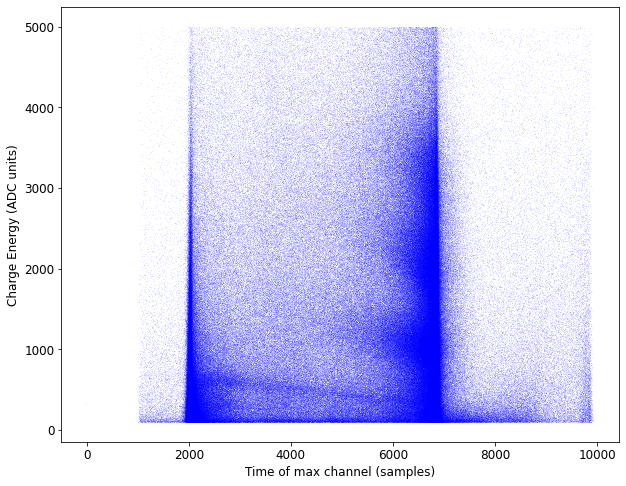

In [13]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12


charge_energy = data_df['TotalTileEnergy']
time_of_max_channel = data_df['TimeOfMaxChannel']

#data can also be selected for example a specific energy range
mask = (data_df['TotalTileEnergy']>100) & (data_df['TotalTileEnergy']<5000)\
& (data_df['TotalSiPMEnergy']>100) & (data_df['TotalSiPMEnergy']<2000000)

#make a 2d histogram with the selected data (for example charge energy vs light energy)

xbins = np.linspace(0.,6500.,200)
ybins = np.linspace(0.,5000.,100)

#plt.hist2d(time_of_max_channel[mask], charge_energy[mask],bins=(xbins,ybins))
plt.plot(time_of_max_channel[mask], charge_energy[mask],'o',color=(0.,0.,1.,0.1),markersize=1.,markeredgecolor=(0.,0.,0.,0.))

plt.xlabel('Time of max channel (samples)')
plt.ylabel('Charge Energy (ADC units)')

Here we see a couple of features worth noting:
* There are two distinct cutoffs on the "time" axis, which correspond to the top and bottom of the detector. The trigger is at 1000 samples, so events near 1000 samples come from interactions just below the anode. Events near ~6000 samples come from the cathode (at the bottom).
* We can see a band at ~600ADC in the Charge Energy spectrum, which corresponds to the alpha signals from Bi212 decays.


We'll do two things to clean this up a bit. First, let's convert the X-axis into something a bit more meaningful -- the actual drift time.

Text(0, 0.5, 'Charge Energy (ADC units)')

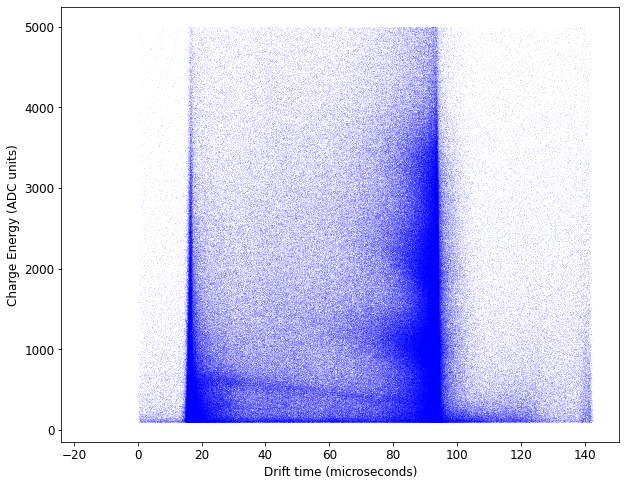

In [14]:
drift_time = (time_of_max_channel - analysis_config.run_parameters['Charge Pretrigger Length [samples]']) \
               * analysis_config.run_parameters['Sampling Period [ns]'] / 1000.


#plt.hist2d(time_of_max_channel[mask], charge_energy[mask],bins=(xbins,ybins))
plt.plot(drift_time[mask], charge_energy[mask],'o',color=(0.,0.,1.,0.1),markersize=1.,markeredgecolor=(0.,0.,0.,0.))

plt.xlabel('Drift time (microseconds)')
plt.ylabel('Charge Energy (ADC units)')


Next, we can select events where the charge is only on one or two channels. This should be the case for most alpha events, since the ionization is so localized. 




Text(0, 0.5, 'Charge Energy (ADC units)')

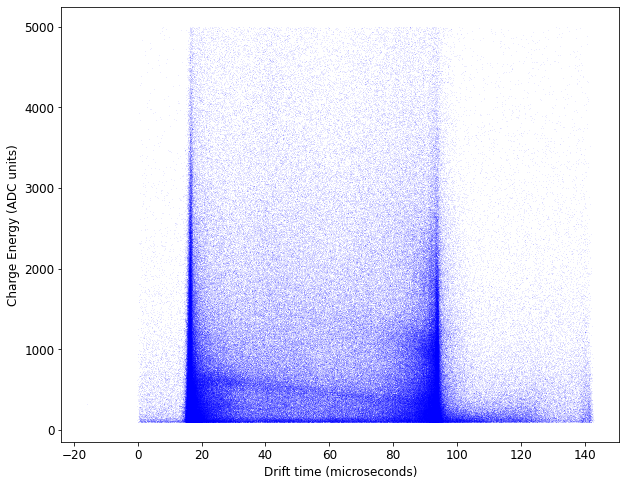

In [15]:
mask = (data_df['TotalTileEnergy']>100) & (data_df['TotalTileEnergy']<5000) \
        & (data_df['TotalSiPMEnergy']>100) & (data_df['TotalSiPMEnergy']<2000000) \
        & (data_df['NumTileChannelsHit'] < 3)

#plt.hist2d(time_of_max_channel[mask], charge_energy[mask],bins=(xbins,ybins))
plt.plot(drift_time[mask], charge_energy[mask],'o',color=(0.,0.,1.,0.1),markersize=1.,markeredgecolor=(0.,0.,0.,0.))

plt.xlabel('Drift time (microseconds)')
plt.ylabel('Charge Energy (ADC units)')
